# **Assignment2**


Group #1: 
* Saba Farshbaf (UCID: 30236369)
* Nima Karbaschi (UCID: 30214865)

This assignment focuses on developing a multimodal machine learning model to classify waste materials into four categories (*Blue*, *Black*, *Green*, or *TTR*) according to the City of Calgary's waste management guidelines. The classification is based on both visual data (images) and textual descriptions of the waste items.

The proposed approach implements a hybrid architecture combining image and text processing capabilities. For image classification, we utilized the *ResNet18* model, selected for its deep feature extraction capabilities and implementation efficiency. A preliminary comparative analysis between *MobileNet* and ResNet18 demonstrated slightly better performance with the latter for our specific use case.
For text processing, we employed *DistilBert*, a transformer-based model known for its effectiveness in processing short text sequences, which aligns well with our project requirements of analyzing brief waste descriptions.

The methodology involves parallel processing of both modalities: textual descriptions are processed through DistilBert after being extracted as CSV files, while images undergo feature extraction through ResNet18. The features extracted from both models are combined and passed through a fully-connected network for final waste category classification.

The implementation details are presented in the following sections.g sections.

# Import Essential Libraries

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from transformers import DistilBertModel, DistilBertTokenizer


# **Import DataSet Directory**
The data is organized in *train*/*val*/*test* folders. Each containing subfolders for different garbage classes.


In [3]:
directory = '/kaggle/input/garbage-data/garbage_data'

#both image and text directories are same, but for clarification we used different names.

train_image = '/kaggle/input/garbage-data/garbage_data/train'
val_image = '/kaggle/input/garbage-data/garbage_data/val'
test_image = '/kaggle/input/garbage-data/garbage_data/test'

train_text = '/kaggle/input/garbage-data/garbage_data/train'
val_text = '/kaggle/input/garbage-data/garbage_data/val'
test_text = '/kaggle/input/garbage-data/garbage_data/test'

# **Define Hyperparameters**

In [ ]:
# Defining train phase Hyperparameters

batch_size = 32                        # Number of samples per batch
learning_rate = 1e-5                   # Learning rate for optimizer
epochs = 20                            # Number of training epochs
num_workers = 4                        # Number of parallel processes for data loading
max_length = 24
classes = ['Black', 'Blue', 'Green', 'TTR']

# **Check if GPU is available**


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Create CSV file for captions**
Creates a CSV file containing image paths, captions, and labels.<br>
Captions are extracted from filenames by removing numbers and special characters.

In [6]:
# Creating CSV format file for all train, validation and test (save extracted captions as label)
def create_csv(data_directory, csv_filename):
    data = []
    
    if not os.path.exists(data_directory):
        print(f"Directory does not exist: {data_directory}")
        return
    
    for class_name in sorted(os.listdir(data_directory)):
        class_path = os.path.join(data_directory, class_name)
        if os.path.isdir(class_path):
            for img_filename in os.listdir(class_path):
                img_path = os.path.join(class_path, img_filename)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Clean caption by removing digits and special characters
                    caption = os.path.splitext(img_filename)[0].replace('_', ' ').translate(str.maketrans('', '', '0123456789')).strip()
                    data.append([img_path, caption, class_name])

    # Save to CSV file
    df = pd.DataFrame(data, columns=['image_path', 'caption', 'label'])
    df.to_csv(f"{csv_filename}.csv", index=False)
    print(f"{csv_filename}.csv saved with {len(df)} entries.")

# Create CSVs
create_csv(train_text, 'train')
create_csv(val_text, 'val')
create_csv(test_text, 'test')

train.csv saved with 10200 entries.
val.csv saved with 1800 entries.
test.csv saved with 3431 entries.


# **Image transforming**
These transformations help in data augmentation and normalization.

In [8]:
# Define Image Transformations
imageTransforms = transforms.Compose([
    transforms.Resize((224, 224)),               # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),           # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),             # Randomly flip images vertically
    transforms.ToTensor(),                       # Convert images to PyTorch tensors
    # Normalize pixel values based on ImageNet normalization data:
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define Transforms for the test Dataset
imageTransforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# **Creating multi model data set**
Create a custom dataset that handles both images and text captions for a multimodal classification task.


In [ ]:
#initialize a tokenizer using DistilBERT, a lightweight version of BERT.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class MultimodalDataset(Dataset):
    def __init__(self, csv_file, transform=None, tokenizer=None, max_length=max_length):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image, text, and label data for the given index
        img_path = self.data.iloc[idx]['image_path']
        caption = str(self.data.iloc[idx]['caption'])
        label = self.data.iloc[idx]['label']
        
        # Process image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Process text using the tokenizer
        tokens = self.tokenizer(
            caption,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Convert label to numeric index
        label_idx = classes.index(label) if label in classes else -1

        return {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'label': torch.tensor(label_idx, dtype=torch.long)
        }

# **Initialize data sets and data loaders**

In [10]:
# Initialize Datasets
train_dataset = MultimodalDataset('/kaggle/working/train.csv', transform=imageTransforms, tokenizer=tokenizer)
val_dataset = MultimodalDataset('/kaggle/working/val.csv', transform=imageTransforms, tokenizer=tokenizer)
test_dataset = MultimodalDataset('/kaggle/working/test.csv', transform=imageTransforms_test, tokenizer=tokenizer)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# **Define Combined Model Architecture**
It's a Neural network that combines both image and text features for classification. <br>
It Uses *ResNet18* for image processing and *DistilBERT* for text processing.

In [12]:
class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()
        # Load Pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()                                  # Remove the final classification layer
        
        # Load Pretrained DistilBERT
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        
        # Combined Feature Layers
        self.fc = nn.Sequential(
            nn.Linear(512 + 768, 256),                                 # Combine image (512) and text (768) features
            nn.BatchNorm1d(256),                                       # Normalize the combined features
            nn.ReLU(),                                                 # Activation function
            nn.Dropout(0.3),                                           # Dropout for prevent overfitting
            nn.Linear(256, len(classes))                               # Final classification layer
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image through ResNet
        img_features = self.resnet(image)
        # Process text through DistilBERT
        text_features = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        # Combine features and make final prediction:
        combined_features = torch.cat((img_features, text_features), dim=1)
        return self.fc(combined_features)

model = MultimodalModel().to('cuda' if torch.cuda.is_available() else 'cpu')

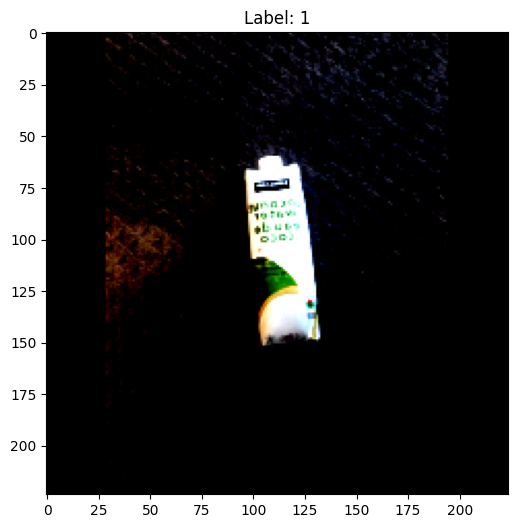

In [ ]:
# Display an image sample with its corresponding label
train_batch = next(iter(train_loader))                     # Get the first batch from train_loader
image_tensor = train_batch['image'][0].cpu().numpy()       # Extract the first image in the batch
label = train_batch['label'][0].item()                     # Extract the label of the first image

# Define the correct label-to-class mapping
label_to_class = {0: 'Black', 1: 'Blue', 2: 'Green', 3: 'TTR'}

# Map the numeric label to the corresponding class name
class_name = label_to_class[label]

# Plot the image with the correct label
plt.figure(figsize=(6, 6))
plt.imshow(image_tensor.transpose(1, 2, 0))                # Convert CxHxW to HxWxC for plotting
plt.title(f"Class: {class_name}")                          # Display the class name in the title
plt.axis('off')                                            # Turn off axis for better visualization
plt.show()

In [17]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    # Adjust epochs_range to match the length of the metrics lists
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Train Loss and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Train Accuracy and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Train and Validate the Model**
It trains the model and validates its performance after each epoch.<br>
It also keeps track of losses and accuracies for both training and validation.


Input arguments:
- *model:* The MultimodalModel instance combining ResNet18 and DistilBERT
- *train_loader:* DataLoader containing training data
- *val_loader:* DataLoader containing validation data
- *epochs:* Number of complete passes through the training data

Epoch 1/20


100%|██████████| 319/319 [03:20<00:00,  1.59it/s]

Train Loss: 0.6497, Accuracy: 76.36%


Val Loss: 0.3685, Accuracy: 86.78%
New best validation loss: 0.3685. Saving model.
Checkpoint saved at epoch 1 with validation loss 0.3685.
Epoch 2/20


100%|██████████| 319/319 [03:09<00:00,  1.69it/s]

Train Loss: 0.3474, Accuracy: 88.80%


Val Loss: 0.3089, Accuracy: 89.11%
New best validation loss: 0.3089. Saving model.
Checkpoint saved at epoch 2 with validation loss 0.3089.
Epoch 3/20


100%|██████████| 319/319 [03:08<00:00,  1.69it/s]

Train Loss: 0.2659, Accuracy: 92.00%


Val Loss: 0.3018, Accuracy: 89.44%
New best validation loss: 0.3018. Saving model.
Checkpoint saved at epoch 3 with validation loss 0.3018.
Epoch 4/20


100%|██████████| 319/319 [03:09<00:00,  1.69it/s]

Train Loss: 0.2380, Accuracy: 92.47%


Val Loss: 0.3004, Accuracy: 89.89%
New best validation loss: 0.3004. Saving model.
Checkpoint saved at epoch 4 with validation loss 0.3004.
Epoch 5/20


100%|██████████| 319/319 [03:08<00:00,  1.69it/s]

Train Loss: 0.2160, Accuracy: 93.39%


Val Loss: 0.3009, Accuracy: 89.56%
Epoch 6/20


100%|██████████| 319/319 [03:08<00:00,  1.69it/s]

Train Loss: 0.1984, Accuracy: 94.08%


Val Loss: 0.2996, Accuracy: 90.00%
New best validation loss: 0.2996. Saving model.
Checkpoint saved at epoch 6 with validation loss 0.2996.
Epoch 7/20


100%|██████████| 319/319 [03:08<00:00,  1.69it/s]

Train Loss: 0.1882, Accuracy: 94.31%


Val Loss: 0.3022, Accuracy: 89.89%
Epoch 8/20


100%|██████████| 319/319 [03:09<00:00,  1.69it/s]

Train Loss: 0.1864, Accuracy: 94.51%


Val Loss: 0.3001, Accuracy: 89.94%
Epoch 9/20


100%|██████████| 319/319 [03:09<00:00,  1.68it/s]

Train Loss: 0.1754, Accuracy: 94.76%


Val Loss: 0.3013, Accuracy: 89.89%
Epoch 10/20


100%|██████████| 319/319 [03:07<00:00,  1.70it/s]

Train Loss: 0.1726, Accuracy: 94.81%


Val Loss: 0.3071, Accuracy: 89.89%
Epoch 11/20


100%|██████████| 319/319 [03:07<00:00,  1.70it/s]

Train Loss: 0.1750, Accuracy: 94.82%


Val Loss: 0.3069, Accuracy: 90.06%
Early stopping after 11 epochs due to no improvement.

Average Training Loss: 0.25572176636099797
Average Training Accuracy: 91.84848484848486
Average Validation Loss: 0.3088915291222991
Average Validation Accuracy: 89.4949494949495


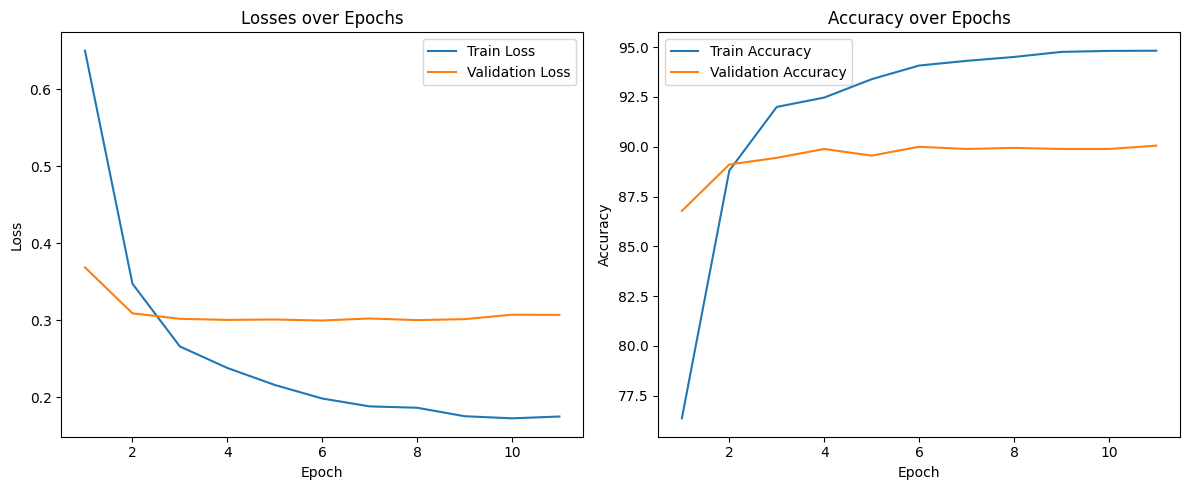

In [ ]:
# Define path for saving model checkpoints
checkpoint_path = "checkpoint.pth"

# Function to save the model checkpoint
def save_checkpoint(model, optimizer, epoch, val_loss, best_loss, checkpoint_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),                                         # Save model parameters
        'optimizer_state_dict': optimizer.state_dict(),                                 # Save optimizer state
        'epoch': epoch,                                                                 # Save current epoch
        'val_loss': val_loss,                                                           # Save current validation loss
        'best_loss': best_loss                                                          # Save best validation loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1} with validation loss {val_loss/len(val_loader):.4f}.")


# Function to load the model checkpoint
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    print(f"Checkpoint loaded from epoch {epoch+1} with validation loss {val_loss/len(val_loader):.4f}.")
    return epoch, best_loss



# Define train_validate function with checkpointing and early stopping
def train_validate(model, train_loader, val_loader, epochs, device, optimizer, scheduler, criterion):
    
    # Initialize lists to track metrics over time
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_loss = 1e+20                                                                    # Initialize best_loss to a very high value
    epochs_without_improvement = 0                                                       # To track patience for early stopping
    patience = 5                                                                         # Early stopping patience

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training Phase
        model.train()                                                                    # Set model to training mode
        train_loss, correct, total = 0, 0, 0
        for batch in tqdm(train_loader):
            # Zero gradients for each batch
            optimizer.zero_grad()
            # Move batch data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass and loss calculation
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()

            # Accumulate batch statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Update learning rate scheduler
        scheduler.step()

        # Calculate training accuracy and store metrics
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation Phase
        model.eval()                                                                      # Set model to evaluation mode
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():                                                             # Disable gradient calculation
            for batch in val_loader:
                # Move batch data to device
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                # Forward pass and loss calculation
                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)

                # Accumulate batch statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate validation accuracy and store metrics
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

        # Save the best model based on the lowest validation loss
        if val_loss < best_loss:
            print(f"New best validation loss: {val_loss/len(val_loader):.4f}. Saving model.")
            # Save the model with the best validation loss
            torch.save(model.state_dict(), "best_model.pth")
            best_loss = val_loss  # Update the best loss

            # Save the checkpoint
            save_checkpoint(model, optimizer, epoch, val_loss, best_loss, checkpoint_path)
            epochs_without_improvement = 0  # Reset the patience counter
        else:
            epochs_without_improvement += 1

        # Early stopping logic
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch+1} epochs due to no improvement.")
            break

    # Calculate and print overall metrics
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

    print("\nAverage Training Loss:", avg_train_loss)
    print("Average Training Accuracy:", avg_train_accuracy)
    print("Average Validation Loss:", avg_val_loss)
    print("Average Validation Accuracy:", avg_val_accuracy)


    # Plot the metrics (assuming a plot_metrics function is defined elsewhere)
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)
    # Return metrics for plotting
    return train_losses, val_losses, train_accuracies, val_accuracies, epoch + 1


# Initialize optimizer, scheduler, and criterion
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.0001)                       # AdamW optimizer with weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)                        # Learning rate scheduler
criterion = nn.CrossEntropyLoss()                                                               # Loss function

train_losses, val_losses, train_accuracies, val_accuracies, actual_epochs = train_validate(
    model, train_loader, val_loader, epochs=epochs, device=device, 
    optimizer=optimizer, scheduler=scheduler, criterion=criterion
)

#plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, actual_epochs)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)


# **Test the Model**
It evaluates the trained model on the test dataset and visualizes results <br>.
Input arguments:
s:
- *model:* Trained MultimodalModel instance
- *test_loader:* DataLoader containing test data
- *criterion:* Loss function (CrossEntropyLoss in this case)
- *classes:* List of class names ['Blue', 'Black', 'Green', 'TTR']
- *device:* Device to run the model on (GPU/CPU)GPU/CPU)

In [24]:
# Load the best performing model from disk and move it to the specified device (CPU/GPU)
model = MultimodalModel().to(device)
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

def test_model(model, test_loader, criterion, classes, device):

    # Prepare model for evaluation
    model.to(device)
    model.eval()

    # Initialize tracking variables for metrics
    all_preds = []                  # Store all predictions
    all_labels = []                 # Store all true labels
    test_loss = 0.0                 # Accumulate total loss
    correct = 0                     # Count of correct predictions
    total = 0                       # Total number of samples 

    # Disable gradient calculation for efficiency during testing
    with torch.no_grad():
        # Iterate through test data batches with progress bar
        for batch in tqdm(test_loader, desc="Testing"):
            # Move batch data to appropriate device
            images = batch['image'].to(device)                          # Image inputs
            input_ids = batch['input_ids'].to(device)                   # Text token IDs
            attention_mask = batch['attention_mask'].to(device)         # Text attention mask
            labels = batch['label'].to(device)                          # True labels

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy metrics
            _, predicted = torch.max(outputs, 1)                       # Get predicted class
            total += labels.size(0)                                    # Update total sample count
            correct += (predicted == labels).sum().item()              # Update correct prediction count

            # Store predictions and labels for later use
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate and display final metrics
    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    # Print summary metrics
    print(f"\nTest Results:")
    print(f"Average Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Generate and display detailed classification metrics
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))
    
    # Create and display confusion matrix visualization
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels



Starting model testing...


Testing: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]



Test Results:
Average Test Loss: 0.4726
Test Accuracy: 84.35%

Classification Report:
              precision    recall  f1-score   support

       Black       0.78      0.71      0.74       695
        Blue       0.81      0.91      0.86      1085
       Green       0.90      0.94      0.92       799
         TTR       0.88      0.78      0.83       852

    accuracy                           0.84      3431
   macro avg       0.84      0.83      0.84      3431
weighted avg       0.84      0.84      0.84      3431



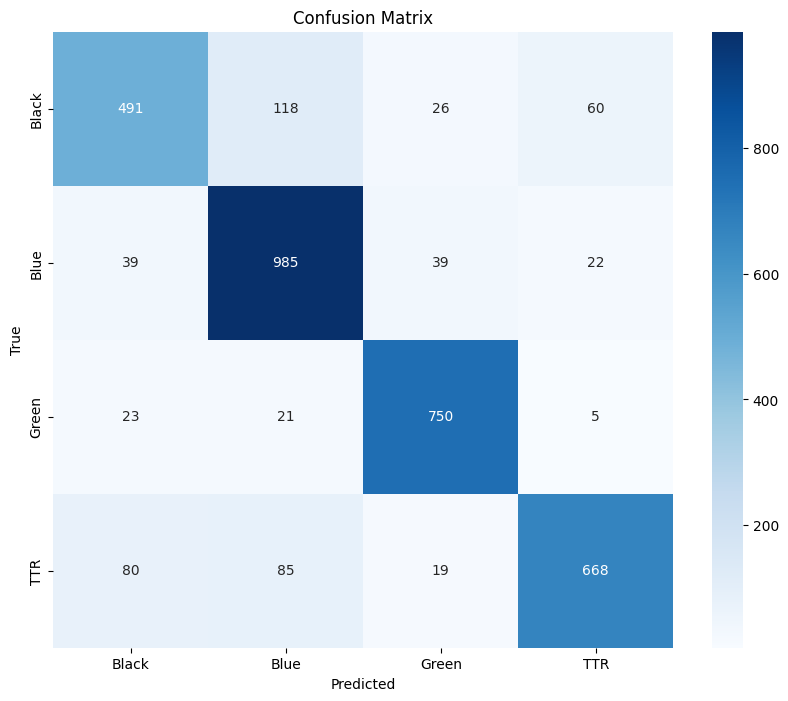


Plotting misclassified examples...


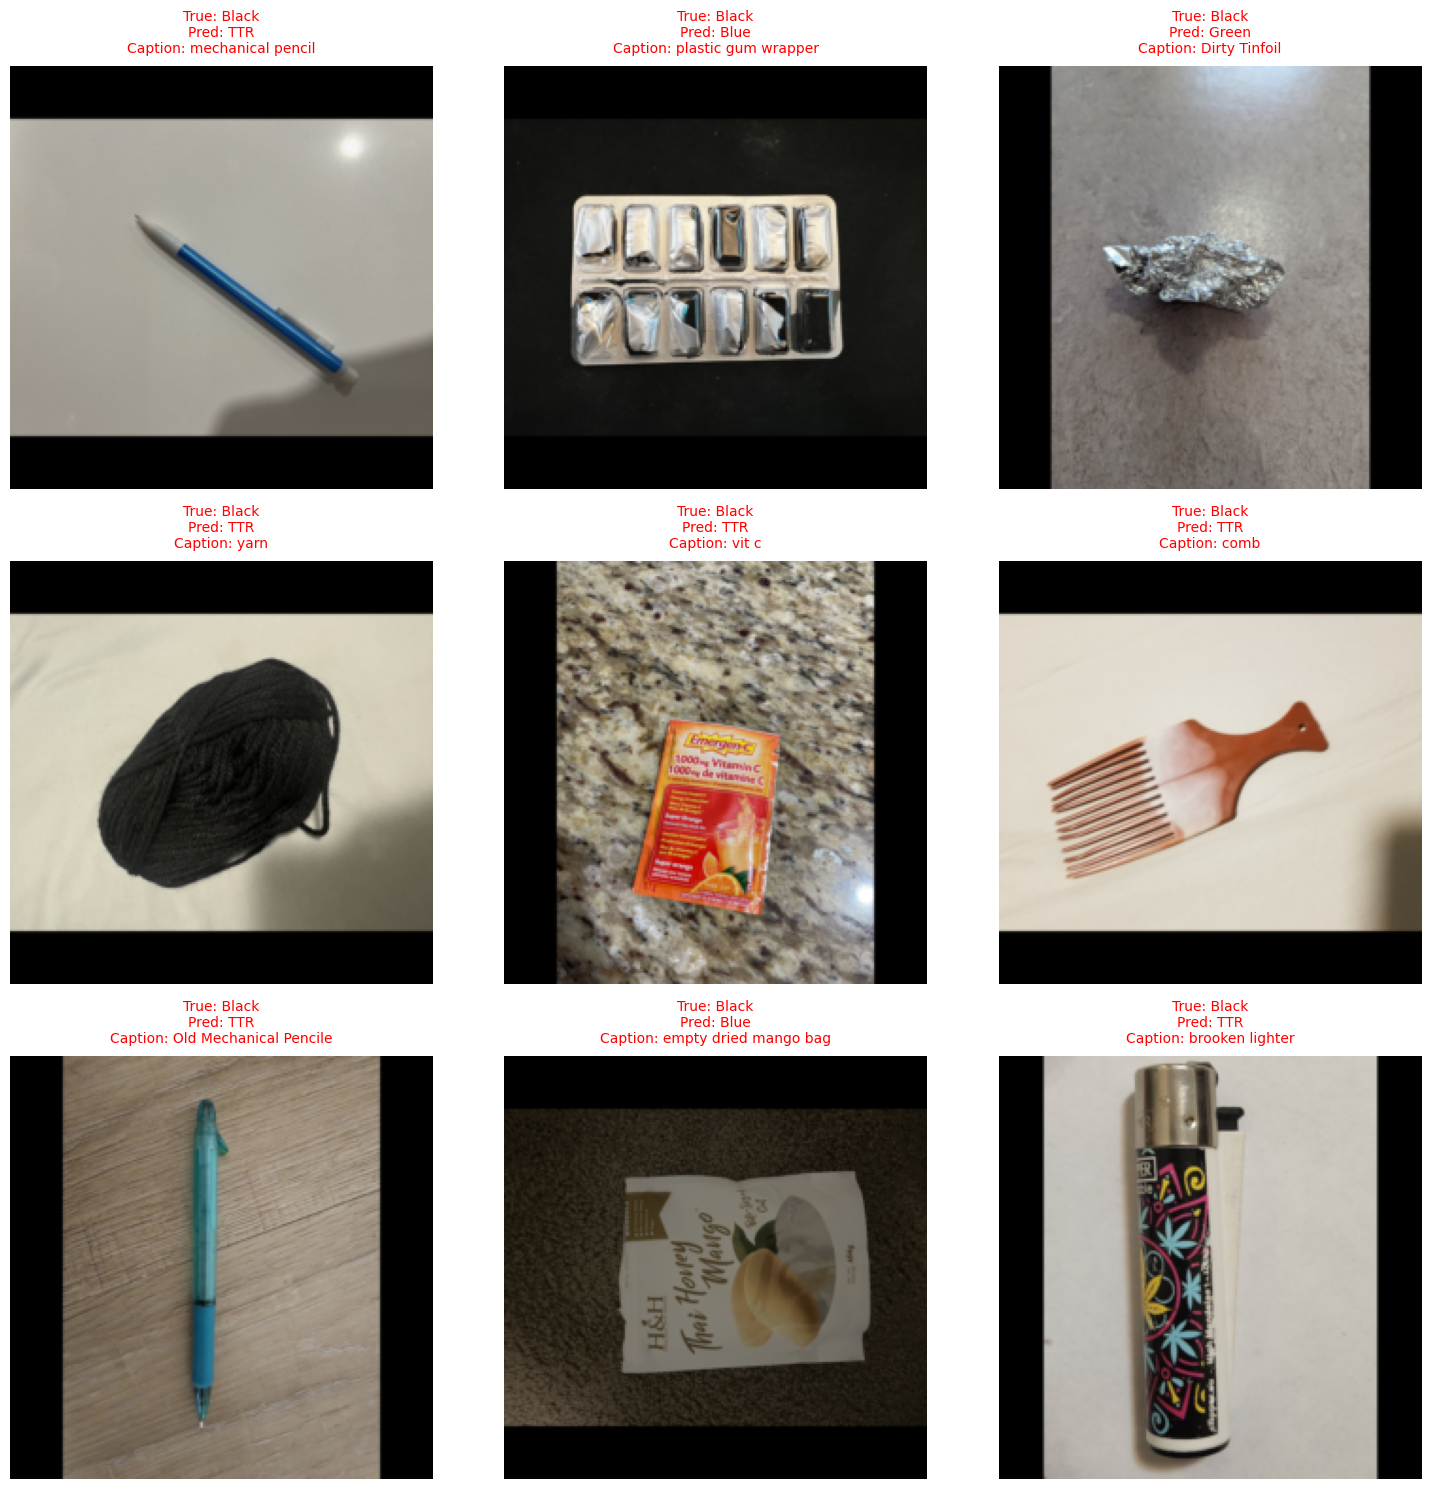

In [25]:
# Visualize examples where the model made incorrect predictions.
def plot_incorrect_predictions(test_dataset, preds, labels, classes, num_examples=9):
    """
    Plot examples of incorrect predictions
    """
    # Find incorrect predictions
    incorrect_indices = [i for i in range(len(labels)) if preds[i] != labels[i]]
    
    if not incorrect_indices:
        print("No incorrect predictions found!")
        return
        
    # Calculate grid dimensions for plotting
    n = min(num_examples, len(incorrect_indices))
    rows = (n + 2) // 3  # Ceiling division

    # Create figure for visualization
    plt.figure(figsize=(15, 5 * rows))

    # Plot each misclassified example
    for i, idx in enumerate(incorrect_indices[:n]):
        plt.subplot(rows, 3, i + 1)
        
        # Get the sample
        sample = test_dataset[idx]
        image = sample['image']
        
        # Reverse normalization for display
        img_display = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)
        
        # Display image
        plt.imshow(img_display)
        
        # Get caption from dataset
        caption = test_dataset.data.iloc[idx]['caption']
        
        # Add title with prediction info
        title = f'True: {classes[labels[idx]]}\nPred: {classes[preds[idx]]}\n'
        title += f'Caption: {caption[:50]}{"..." if len(caption) > 50 else ""}'
        
        plt.title(title, color='red', fontsize=10, pad=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('misclassified_examples.png', dpi=300, bbox_inches='tight')
    plt.savefig('misclassified_examples.svg', format='svg', bbox_inches='tight')
    plt.show()

# Run the testing and get predictions
print("Starting model testing...")
predictions, true_labels = test_model(model, test_loader, criterion, classes, device)
print("\nPlotting misclassified examples...")
plot_incorrect_predictions(test_dataset, predictions, true_labels, classes)